## model: godzina - dzien tygodnia

### getting demand data

In [52]:
import pandas as pd
from datetime import date
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

weather_start_year = 2014
end_dt = '2019-12-31'
# 2 months:
# start_dt = '2019-02-01'

#6 months:
# start_dt = '2018-10-01'

# 12 months:
# start_dt = '2018-04-01'

# #24 months:
# start_dt = '2017-04-01'

# # #60 months:
start_dt = '2014-01-01'

weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start_dt, end_dt)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2014-01-01 01:00:00,14670.613,2014-01-01 01:00:00
2014-01-01 02:00:00,13988.263,2014-01-01 02:00:00
2014-01-01 03:00:00,13305.350,2014-01-01 03:00:00
2014-01-01 04:00:00,12837.075,2014-01-01 04:00:00
2014-01-01 05:00:00,12569.463,2014-01-01 05:00:00
...,...,...
2019-12-31 20:00:00,18114.775,2019-12-31 20:00:00
2019-12-31 21:00:00,16998.238,2019-12-31 21:00:00
2019-12-31 22:00:00,16239.375,2019-12-31 22:00:00


In [53]:
dataAll
#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']] 
# modelData2.set_index('DataGodz')
# modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20, regresor = None):
    start = datetime.datetime.now()

    #auto ARIMA
    m = auto_arima(dane, 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = True,
           exogenous = regresor)#.summary()
    print('autoARIMA time: ' + str(datetime.datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse',exog = regresor)
    model_fit = model.fit() 
    
    print('fit time = ' + str(datetime.datetime.now() - fit_start))
    return model_fit

### Getting weather data

In [4]:
weather_cols = [
'Kod stacji'
,'Nazwa stacji'
,'Rok' 
,'Miesiąc' 
,'Dzień'
,'Godzina' 
,'Wysokość podstawy chmur CL CM szyfrowana [kod]'
,'Status pomiaru HPOD' 
,'Wysokość podstawy niższej  [m]'
,'Status pomiaru HPON' 
,'Wysokość podstawy wyższej [m]'
,'Status pomiaru HPOW' 
,'Wysokość podstawy tekstowy [opis]' 
,'Pomiar przyrzadem 1 (niższa) [P]'
,'Pomiar przyrzadem 2 (wyższa) [P]'
,'Widzialność  [kod]' 
,'Satus pomiaru WID' 
,'Widzialność operatora [m]' 
,'Status pomiaru WIDO' 
,'Widzialność automat [m]'
,'Status pomiaru WIDA' 
,'Zachmurzenie ogólne [oktanty]'
,'Status pomiaru NOG'  
,'Kierunek wiatru  [°]'
,'Status pomiaru KRWR' 
,'Prędkość wiatru  [m/s]' ######################################
,'Status pomiaru FWR'  
,'Poryw wiatru  [m/s]' 
,'Status pomiaru PORW' 
,'Temperatura powietrza [°C]' ######################################
,'Status pomiaru TEMP' 
,'Temperatura termometru zwilżonego [°C]'
,'Status pomiaru TTZW' 
,'Wskaźnik wentylacji [W/N]' 
,'Wskaźnik lodu [L/W]' 
,'Ciśnienie pary wodnej [hPa]'  
,'Status pomiaru CPW'  
,'Wilgotność względna [%]'
,'Status pomiaru WLGW' 
,'Temperatura punktu rosy [°C]' 
,'Status pomiaru TPTR' 
,'Ciśnienie na pozimie stacji [hPa]'  
,'Status pomiaru PPPS' 
,'Ciśnienie na pozimie morza [hPa]'
,'Status pomiaru PPPM' 
,'Charakterystyka tendencji [kod]' 
,'Wartość tendencji [wartość]'  
,'Status pomiaru APP'  
,'Opad za 6 godzin [mm]'  
,'Status pomiaru WO6G'
,'Rodzaj opadu za 6 godzin [kod]'
,'Status pomiaru ROPT'
,'Pogoda bieżąca [kod]'
,'Pogoda ubiegła [kod]'
,'Zachmurzenie niskie [oktanty]'
,'Status pomiaru CLCM'
,'Chmury CL [kod]'
,'Status pomiaru CHCL'
,'Chmury CL tekstem'
,'Chmury CM [kod]'
,'Status pomiaru CHCM'
,'Chmury CM tekstem'
,'Chmury CH [kod]'
,'Status pomiaru CHCH'
,'Chmury CH tekstem'
,'Stan gruntu [kod]'
,'Status pomiaru SGRN'
,'Niedosyt wilgotności [hPa}'
,'Status pomiaru DEFI'
,'Usłonecznienie'
,'Status pomiaru USLN'
,'Wystąpienie rosy [0/1]'
,'Status pomiaru ROSW'
,'Poryw maksymalny za okres WW [m/s]'
,'Status pomiaru PORK'
,'Godzina wystąpienia porywu'
,'Minuta wystąpienia porywu'
,'Temperatura gruntu -5 [°C]'
,'Status pomiaru TG05'
,'Temperatura gruntu -10 [°C]'
,'Status pomiaru TG10'
,'Temperatura gruntu -20 [°C]'
,'Status pomiaru TG20'
,'Temperatura gruntu -50 [°C]'
,'Status pomiaru TG50'
,'Temperatura gruntu -100 [°C]'
,'Status pomiaru TG100'
,'Temperatura minimalna za 12 godzin  [°C]'
,'Status pomiaru TMIN'
,'Temperatura maksymalna za 12 godzin [°C]'
,'Status pomiaru TMAX'
,'Temperatura minimalna przy gruncie za 12 godzin [°C]'
,'Status pomiaru TGMI'
,'Równoważnik wodny śniegu [mm/cm]'
,'Status pomiaru RWSN'
,'Wysokość pokrywy śnieżnej [cm]'
,'Status pomiaru PKSN'
,'Wysokość świeżo spadłego śniegu  [cm]'
,'Status pomiaru HSS'
,'Wysokość śniegu na poletku [cm]'
,'Status pomiaru GRSN'
,'Gatunek śniegu  [kod]'
,'Ukształtowanie pokrywy [kod]'
,'Wysokość próbki [cm]'
,'Status pomiaru HPRO'
,'Ciężar próbki [g]'
,'Status pomiaru CIPR'
]

In [5]:
def readWeatherFile(file_name):
    file = '../Additional Data/Weather/' + file_name
    df = pd.read_csv(filepath_or_buffer = file
                     ,engine='python'
                     ,sep = ','
                     ,header = None
                    )

    df.columns = weather_cols
    return df
# test:
# readWeatherFile('s_t_690_2017.csv')

In [6]:
# getting list of s_d_t .csv files

import glob
file_names_list = (glob.glob("..\\Additional Data\\Weather\\s_t_*.csv"))
lst=[]

for file_name in file_names_list:
    file_name = file_name[-16:]
    file_name = file_name.replace("\\","")
    lst.append(file_name)
#     print(file_name)
file_names_list = lst
lst=[]

In [7]:
names_to_drop=[]
for i in file_names_list:
    if(int(i[-8:-4]) < weather_start_year):
        names_to_drop.append(i)
for i in names_to_drop:
    file_names_list.remove(i)
file_names_list

['s_t_01_2020.csv',
 's_t_02_2020.csv',
 's_t_03_2020.csv',
 's_t_04_2020.csv',
 's_t_05_2020.csv',
 's_t_06_2020.csv',
 's_t_07_2020.csv',
 's_t_08_2020.csv',
 's_t_09_2020.csv',
 's_t_100_2014.csv',
 's_t_100_2015.csv',
 's_t_100_2016.csv',
 's_t_100_2017.csv',
 's_t_100_2018.csv',
 's_t_100_2019.csv',
 's_t_100_2020.csv',
 's_t_105_2014.csv',
 's_t_105_2015.csv',
 's_t_105_2016.csv',
 's_t_105_2017.csv',
 's_t_105_2018.csv',
 's_t_105_2019.csv',
 's_t_105_2020.csv',
 's_t_10_2020.csv',
 's_t_115_2014.csv',
 's_t_115_2015.csv',
 's_t_115_2016.csv',
 's_t_115_2017.csv',
 's_t_115_2018.csv',
 's_t_115_2019.csv',
 's_t_115_2020.csv',
 's_t_120_2014.csv',
 's_t_120_2015.csv',
 's_t_120_2016.csv',
 's_t_120_2017.csv',
 's_t_120_2018.csv',
 's_t_120_2019.csv',
 's_t_120_2020.csv',
 's_t_125_2014.csv',
 's_t_125_2015.csv',
 's_t_125_2016.csv',
 's_t_125_2017.csv',
 's_t_125_2018.csv',
 's_t_125_2019.csv',
 's_t_125_2020.csv',
 's_t_135_2014.csv',
 's_t_135_2015.csv',
 's_t_135_2016.csv',
 '

In [8]:
weatherDF = readWeatherFile(file_names_list[1]).iloc[0:0] #dummy
weatherDF = weatherDF[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
for file_name in file_names_list:
    weatherDF = weatherDF.append(
        readWeatherFile(file_name)[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
        ,ignore_index=True
        )
    print(file_name)
weatherDF.isna().sum()

s_t_01_2020.csv
s_t_02_2020.csv
s_t_03_2020.csv
s_t_04_2020.csv
s_t_05_2020.csv
s_t_06_2020.csv
s_t_07_2020.csv
s_t_08_2020.csv
s_t_09_2020.csv
s_t_100_2014.csv
s_t_100_2015.csv
s_t_100_2016.csv
s_t_100_2017.csv
s_t_100_2018.csv
s_t_100_2019.csv
s_t_100_2020.csv
s_t_105_2014.csv
s_t_105_2015.csv
s_t_105_2016.csv
s_t_105_2017.csv
s_t_105_2018.csv
s_t_105_2019.csv
s_t_105_2020.csv
s_t_10_2020.csv
s_t_115_2014.csv
s_t_115_2015.csv
s_t_115_2016.csv
s_t_115_2017.csv
s_t_115_2018.csv
s_t_115_2019.csv
s_t_115_2020.csv
s_t_120_2014.csv
s_t_120_2015.csv
s_t_120_2016.csv
s_t_120_2017.csv
s_t_120_2018.csv
s_t_120_2019.csv
s_t_120_2020.csv
s_t_125_2014.csv
s_t_125_2015.csv
s_t_125_2016.csv
s_t_125_2017.csv
s_t_125_2018.csv
s_t_125_2019.csv
s_t_125_2020.csv
s_t_135_2014.csv
s_t_135_2015.csv
s_t_135_2016.csv
s_t_135_2017.csv
s_t_135_2018.csv
s_t_135_2019.csv
s_t_135_2020.csv
s_t_155_2014.csv
s_t_155_2015.csv
s_t_155_2016.csv
s_t_155_2017.csv
s_t_155_2018.csv
s_t_155_2019.csv
s_t_155_2020.csv
s_t_160

Nazwa stacji                  0
Rok                           0
Miesiąc                       0
Dzień                         0
Godzina                       0
Prędkość wiatru  [m/s]        0
Temperatura powietrza [°C]    0
dtype: int64

In [9]:
weatherDF['Nazwa stacji'].unique()

array(['BIELSKO-BIAŁA', 'ZAKOPANE', 'KASPROWY WIERCH', 'HALA GĄSIENICOWA',
       'NOWY SĄCZ', 'KROSNO', 'LESKO', 'JELENIA GÓRA', 'ŚNIEŻKA',
       'KŁODZKO', 'OPOLE', 'RACIBÓRZ', 'CZĘSTOCHOWA',
       'KATOWICE-MUCHOWIEC', 'KRAKÓW-BALICE', 'KIELCE-SUKÓW', 'TARNÓW',
       'SANDOMIERZ', 'RZESZÓW-JASIONKA', 'ZAMOŚĆ', 'ZIELONA GÓRA',
       'LEGNICA', 'LESZNO', 'WROCŁAW-STRACHOWICE', 'KALISZ', 'WIELUŃ',
       'ŁÓDŹ-LUBLINEK', 'SULEJÓW', 'KOZIENICE', 'LUBLIN-RADAWIEC',
       'WŁODAWA', 'SŁUBICE', 'GORZÓW WIELKOPOLSKI', 'POZNAŃ-ŁAWICA',
       'KOŁO', 'PŁOCK', 'WARSZAWA-OKĘCIE', 'SIEDLCE', 'TERESPOL',
       'ŚWINOUJŚCIE', 'SZCZECIN', 'RESKO-SMÓLSKO', 'PIŁA', 'CHOJNICE',
       'TORUŃ', 'MŁAWA', 'OLSZTYN', 'MIKOŁAJKI', 'BIAŁYSTOK',
       'KOŁOBRZEG-DŹWIRZYNO', 'KOSZALIN', 'USTKA', 'ŁEBA', 'LĘBORK',
       'HEL', 'GDAŃSK-ŚWIBNO', 'ELBLĄG-MILEJEWO', 'KĘTRZYN', 'SUWAŁKI',
       'KOŁOBRZEG', 'POZNAŃ', 'WARSZAWA', 'WROCŁAW', 'ŁÓDŹ', 'KATOWICE'],
      dtype=object)

In [10]:
# #wybranie top6 zaludnionych
# weatherDF = weatherDF[weatherDF['Nazwa stacji'].isin(
# ['WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
# ])]

In [11]:
#wywalenie odstających
weatherDF = weatherDF[~weatherDF['Nazwa stacji'].isin(
[
#     'WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
    'KASPROWY WIERCH',
    'ŚNIEŻKA',
    'ZAKOPANE'
])]

In [12]:
weatherByStation = weatherDF[
            ['Nazwa stacji',
           'Prędkość wiatru  [m/s]',
           'Temperatura powietrza [°C]']
         ].groupby('Nazwa stacji').mean()

<AxesSubplot:xlabel='Nazwa stacji'>

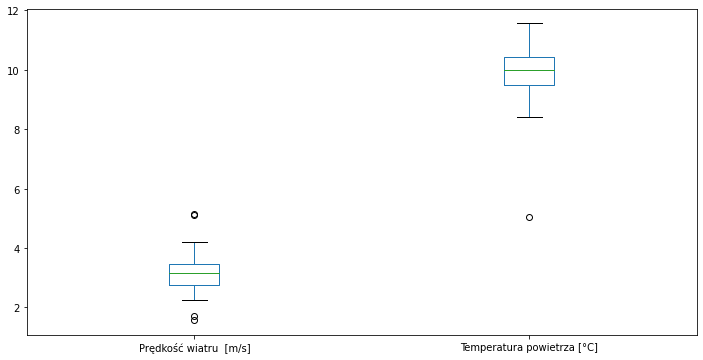

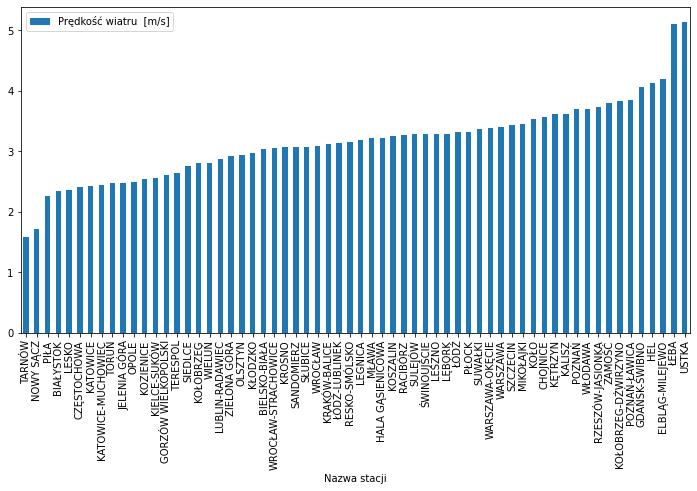

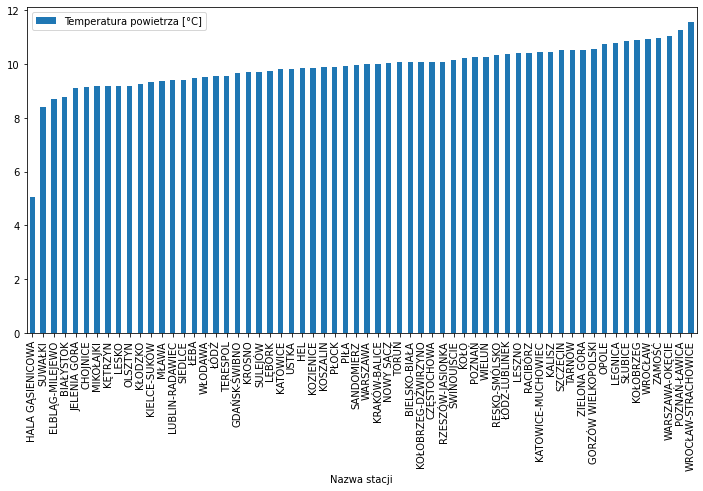

In [13]:
weatherByStation.plot(kind='box', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Prędkość wiatru  [m/s]')
weatherByStation[['Prędkość wiatru  [m/s]']].plot(kind='bar', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Temperatura powietrza [°C]')
weatherByStation[['Temperatura powietrza [°C]']].plot(kind='bar', figsize=(12,6))
# weatherByStation


In [14]:
def date_from_row(x):
    y=x['Rok']
    m=x['Miesiąc']
    d=x['Dzień']
    return date(y,m,d)

In [15]:
weatherDF['DataGodz'] = weatherDF.apply(lambda x: date_from_row(x), axis = 1)
weatherDF['DataGodz'] = pd.to_datetime(weatherDF['DataGodz']) 

weatherDF['DataGodz'] = weatherDF['DataGodz'] + weatherDF['Godzina'].apply(
   lambda x: relativedelta(hours=x)
)

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [16]:
weatherAvg = weatherDF[
            ['Nazwa stacji',
           'Temperatura powietrza [°C]',
            'DataGodz']
         ].groupby('DataGodz',as_index=False).mean()

#### łączenie pogody z zapotrzebowaniem

In [62]:
# dataAll = pd.merge(dataAll, weatherAvg, how='left',on='DataGodz')
dataAll['Rok']

0        2014
1        2014
2        2014
3        2014
4        2014
         ... 
52569    2019
52570    2019
52571    2019
52572    2019
52573    2019
Name: Rok, Length: 52574, dtype: int32

### korelacje

In [19]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [63]:
dataAll[
            ['Temperatura powietrza [°C]',
            'Miesiac',
             'Rok']]

,Temperatura powietrza [°C],Miesiac,Rok
0,0.252941,1,2014
1,0.282353,1,2014
2,0.345098,1,2014
3,0.435294,1,2014
4,0.431373,1,2014
...,...,...,...
52569,4.170370,12,2019
52570,3.894444,12,2019
52571,3.564815,12,2019
52572,3.201852,12,2019


In [65]:
weatherAvgMonth = dataAll[
            ['Temperatura powietrza [°C]',
            'Miesiac',
             'Rok']
         ].groupby(['Miesiac','Rok'],as_index=False).mean()
dataAllMon = dataAll[
    ['Krajowe zapotrzebowanie na moc',
            'Miesiac','Rok']
         ].groupby(['Miesiac','Rok'],as_index=False).mean()

,Miesiac,Rok,Temperatura powietrza [°C]
0,1,2014,-1.556149
1,1,2015,1.344350
2,1,2016,-2.502788
3,1,2017,-3.517098
4,1,2018,1.117026
...,...,...,...
67,12,2015,4.537650
68,12,2016,1.171492
69,12,2017,2.331857
70,12,2018,1.788623


In [67]:
korelacja=[]
for miesiac in range(1,13):
    dane = dataAllMon[dataAllMon['Miesiac'] == miesiac]
    dane2 = weatherAvgMonth[weatherAvgMonth['Miesiac'] == miesiac]
    corrP, _ = pearsonr(dane['Krajowe zapotrzebowanie na moc'], 
                        dane2['Temperatura powietrza [°C]']
                       )
    corrS, _ = spearmanr(dane['Krajowe zapotrzebowanie na moc'], 
                        dane2['Temperatura powietrza [°C]']
                       )
    korelacja.append([miesiac,corrP,corrS])


In [84]:
korelacja = np.matrix(korelacja)
corrP, _ = pearsonr(dataAll['Krajowe zapotrzebowanie na moc'], 
                        dataAll['Temperatura powietrza [°C]']
                       )
corrS, _ = spearmanr(dataAll['Krajowe zapotrzebowanie na moc'], 
                        dataAll['Temperatura powietrza [°C]']
                       )
print('Spearman',corrS)
print('Pearson', corrP)

Spearman -0.12504151492452706
Pearson -0.11923912254946716


In [89]:
korelacja

matrix([[ 1.        , -0.27481953, -0.37142857],
        [ 2.        , -0.76936488, -0.71428571],
        [ 3.        , -0.76928923, -0.54285714],
        [ 4.        , -0.01976696, -0.14285714],
        [ 5.        ,  0.03308183, -0.25714286],
        [ 6.        ,  0.81570878,  0.88571429],
        [ 7.        , -0.15781736, -0.31428571],
        [ 8.        ,  0.46494562,  0.37142857],
        [ 9.        , -0.16493027, -0.14285714],
        [10.        ,  0.50169691,  0.54285714],
        [11.        , -0.37287606, -0.54285714],
        [12.        , -0.57391361, -0.25714286]])

In [87]:
np.reshape(korelacja[:,2],12)

matrix([[-0.37142857, -0.71428571, -0.54285714, -0.14285714, -0.25714286,
          0.88571429, -0.31428571,  0.37142857, -0.14285714,  0.54285714,
         -0.54285714, -0.25714286]])

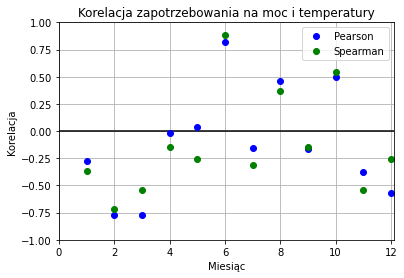

In [88]:
xv1 = 10
plt.plot(korelacja[:,0],
        korelacja[:,1],
        'bo')
plt.plot(korelacja[:,0],
        korelacja[:,2],'go')
plt.legend(['Pearson', 'Spearman'])
plt.grid()
plt.xlabel('Miesiąc')
plt.ylabel('Korelacja')
plt.ylim(-1,1)
plt.xlim(0, 12.1)
plt.hlines(0,-1,13,'black')
plt.title('Korelacja zapotrzebowania na moc i temperatury')
plt.savefig('korelacja zapotrzebowanie temperatura po miesiacu.png')